# Margin Loans Risk Evaluation

In [178]:
import numpy as np
import pandas as pd
from datetime import datetime
from yahoo_fin import options
from yahoo_fin import stock_info as si
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import sys
import warnings
plt.style.use('default')
pio.templates.default = "seaborn"
warnings.simplefilter(action='ignore', category=FutureWarning)
sys.path.append('C:/Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/functions')
sys.path.append('C:/Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/calibration')

from BSpricer import BS_Pricer
from MERTONpricer import Merton_pricer
from KOUpricer import Kou_pricer
from VGpricer import VG_pricer

np.random.seed(27)

### Get Option Data

In [179]:
symbol = 'AAPL'  # AAPL, TSLA, NVDA
stock_data = si.get_data(symbol, start_date='1/15/2016', end_date='1/20/2016')
print(stock_data)
last_price = stock_data['close'].iloc[-1]
print(f'\n{symbol}\'s last_price: ', last_price)

                 open     high     low      close   adjclose     volume ticker
2016-01-15  24.049999  24.4275  23.840  24.282499  22.135742  319335600   AAPL
2016-01-19  24.602501  24.6625  23.875  24.165001  22.028633  212350800   AAPL

AAPL's last_price:  24.165000915527344


#### Simulate Monte Carlo Paths with calibrated parameters

In [180]:
%store -r calls_bs_params_aapl
%store -r puts_bs_params_aapl

# get parameters from OTKO calibration
%store -r otko_mert_params_aapl
%store -r otko_kou_params_aapl
%store -r otko_vg_params_aapl

# get params from mixed calibration: calls+otko
%store -r mixed_mert_params_aapl
%store -r mixed_kou_params_aapl
%store -r mixed_vg_params_aapl
print(otko_kou_params_aapl)

[0.24, 2.3332, 0.4281, 7.4, 5.4527]


### Monte Carlo simulations

In [181]:
days = 252
paths = 10000
T = 1
r = 0.03
q = 0

#### Black Scholes model

In [182]:
# CALLS PARAMS
sigma = calls_bs_params_aapl
Bs1 = BS_Pricer(last_price, r, q, sigma, T, None, None)
Sbs1 = Bs1.BlackScholesPath(days, paths)

# PUTS PARAMS
sigma = puts_bs_params_aapl
Bs2 = BS_Pricer(last_price, r, q, sigma, T, None, None)
Sbs2 = Bs2.BlackScholesPath(days, paths)


CALIBRATED PARAMETER:	 [σ]
1. CALLS:	 0.27243
2. PUTS: 	 0.38218


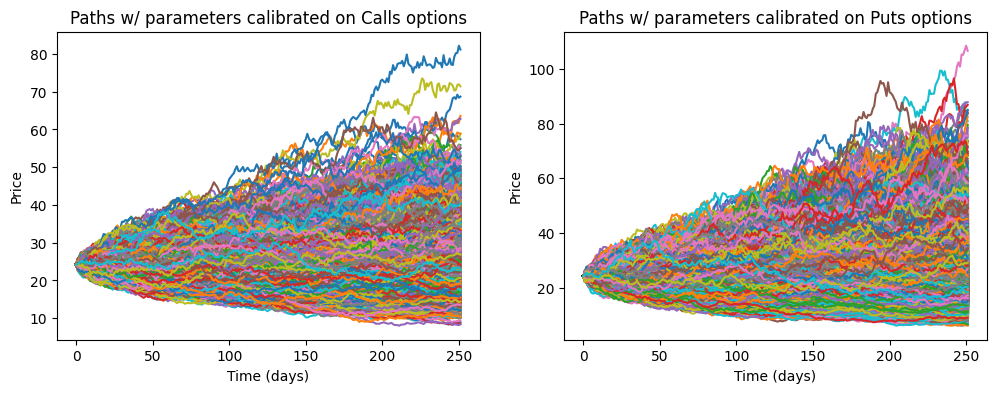

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [183]:
# SHOW PARAMETERS
print(f'CALIBRATED PARAMETER:\t [σ]')
print(f'1. CALLS:\t {calls_bs_params_aapl}')
print(f'2. PUTS: \t {puts_bs_params_aapl}')

options = ['Calls', 'Puts']

fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
for i in range(2): 
    model_ = f'Bs{i+1}'
    paths_ = f'Sbs{i+1}'
    model = locals()[model_]
    paths_ = locals()[paths_]
    model.plotBSPath(paths_, symbol, ax=axes[i])
    axes[i].set_title(f'Paths w/ parameters calibrated on {options[i]} options')

plt.tight_layout()
plt.show()

#### Merton Jump Diffusion paths

In [184]:
# OTKO_PARAMS 
sigma, lambd, m, v = otko_mert_params_aapl
Mert1 = Merton_pricer(last_price, None, T, r, q, sigma, lambd, m, v, None)
Smert1 = Mert1.MertonPath(days, paths)

# MIXED PARAMS
sigma, lambd, m, v = mixed_mert_params_aapl
Mert2 = Merton_pricer(last_price, None, T, r, q, sigma, lambd, m, v, None)
Smert2 = Mert2.MertonPath(days, paths)


CALIBRATED PARAMETERS	 [σ		λ		m		v]
1. OTKO DAILY CLIQUETS:	 [0.22, 3.0223, 0.0346, 0.2274]
2. CALLS+PUTS+OTKO:		 [0.1582, 1.4902, -0.0242, 0.2542]


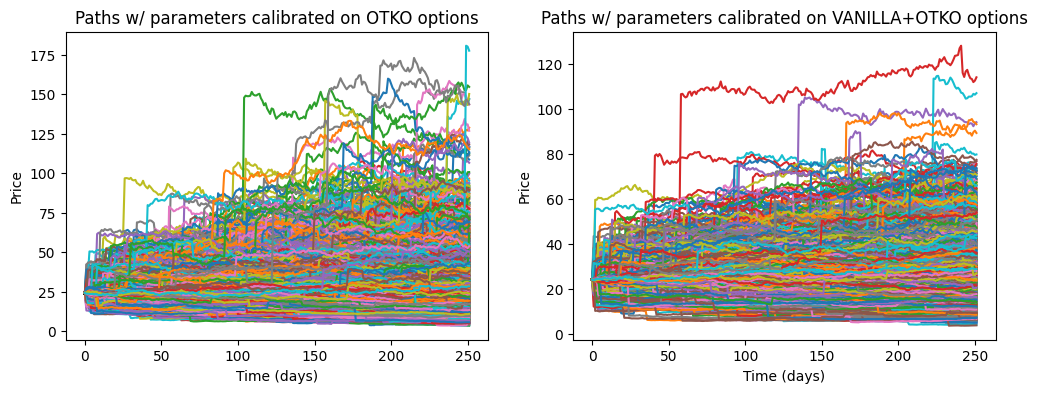

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [185]:
# SHOW PARAMETERS
print(f'CALIBRATED PARAMETERS\t [σ\t\tλ\t\tm\t\tv]')
print(f'1. OTKO DAILY CLIQUETS:\t {otko_mert_params_aapl}')
print(f'2. CALLS+PUTS+OTKO:\t\t {mixed_mert_params_aapl}')

options = ['OTKO', 'VANILLA+OTKO']

fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
for i in range(2): 
    model_ = f'Mert{i+1}'
    paths_ = f'Smert{i+1}'
    model = locals()[model_]
    paths_ = locals()[paths_]
    model.plotMertonPath(paths_, symbol, ax=axes[i])
    axes[i].set_title(f'Paths w/ parameters calibrated on {options[i]} options')

plt.tight_layout()
plt.show()

#### Kou Jump Diffusion paths

In [186]:
# SOLE OTKO
sigma, lambd, p, eta1, eta2 = otko_kou_params_aapl
Kou1 = Kou_pricer(last_price, None, T, r, sigma, lambd,p, eta1, eta2, None)
Skou1 = Kou1.KouPath(days, paths)

# MIXED CALLS+OTKO
sigma, lambd, p, eta1, eta2 = mixed_kou_params_aapl
Kou2 = Kou_pricer(last_price, None, T, r, sigma, lambd,p, eta1, eta2, None)
Skou2 = Kou2.KouPath(days, paths)


CALIBRATED PARAMETERS	 [σ		λ		p		η1		η2]]
1. OTKO DAILY CLIQUETS:	 [0.24, 2.3332, 0.4281, 7.4, 5.4527]
2. CALLS+PUTS+OTKO:		 [0.19, 2.0515, 0.3314, 5.5114, 5.8348]


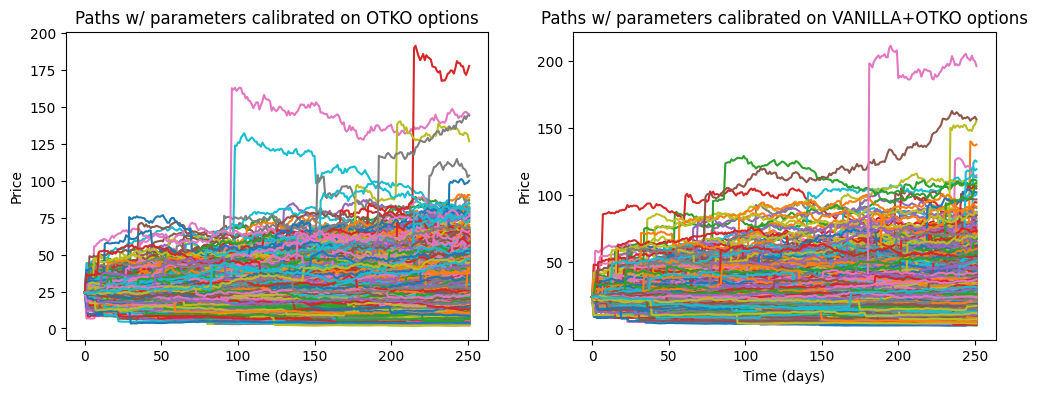

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [187]:
# SHOW PARAMETERS
print(f'CALIBRATED PARAMETERS\t [σ\t\tλ\t\tp\t\tη1\t\tη2]]')
print(f'1. OTKO DAILY CLIQUETS:\t {otko_kou_params_aapl}')
print(f'2. CALLS+PUTS+OTKO:\t\t {mixed_kou_params_aapl}')

fig2, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
for i in range(2): 
    model_ = f'Kou{i+1}'
    paths_ = f'Skou{i+1}'
    model = locals()[model_]
    paths_ = locals()[paths_]
    model.plotKouPath(paths_, symbol, ax=axes[i])
    axes[i].set_title(f'Paths w/ parameters calibrated on {options[i]} options')

plt.tight_layout()
plt.show()

#### Variance gamma model

In [188]:
# OTKO
sigm, theta, nu = otko_vg_params_aapl
VG1 = VG_pricer(last_price, None, T, r, q, sigm, theta, nu, None)
Svg1 = VG1.VarianceGammaPath1(days, paths)

# VANILLA+OTKO
sigm, theta, nu = mixed_vg_params_aapl
VG2 = VG_pricer(last_price, None, T, r, q, sigm, theta, nu, None)
Svg2 = VG2.VarianceGammaPath1(days, paths)


CALIBRATED PARAMETERS	 [σ		θ		v]
3. OTKO DAILY CLIQUETS:	 [0.4737, 0.1965, 0.3018]
4. CALLS+PUTS+OTKO:		 [0.2763, -0.2628, 0.4906]


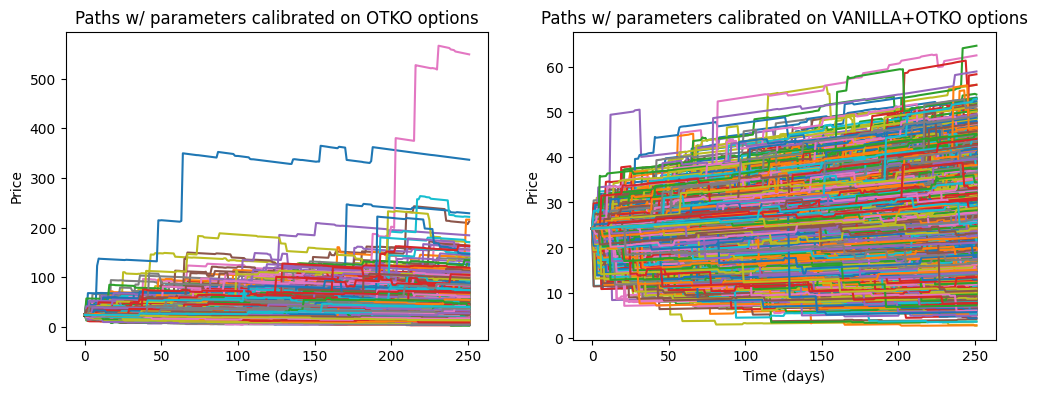

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [189]:
# SHOW PARAMETERS
print(f'CALIBRATED PARAMETERS\t [σ\t\tθ\t\tv]')
print(f'3. OTKO DAILY CLIQUETS:\t {otko_vg_params_aapl}')
print(f'4. CALLS+PUTS+OTKO:\t\t {mixed_vg_params_aapl}')

fig2, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
for i in range(2): 
    model_ = f'VG{i+1}'
    paths_ = f'Svg{i+1}'
    model = locals()[model_]
    paths_ = locals()[paths_]
    model.plotVGPath(paths_, symbol, method='Time changed BM', ax=axes[i])
    axes[i].set_title(f'Paths w/ parameters calibrated on {options[i]} options')

plt.tight_layout()
plt.show()

## Margin Loan Requirements
Checks how many paths are unable to end above the loan amount. 

#### Steps through margin loans evaluation (no margin calls admitted)
1. For each simulated path $i = 1,...,N$ evaluate the final price $S_i (T)$ after the time period $T$
2. Compute $finalvalue = S_i(T) \cdot numshares$ 
3. **If** $finalvalue \geq loanvalue$ **then**
    $ loss_i = 0 $
   **Elseif** $finalvalue < loanvalue$ **then**
    $ loss_i = loanvalue - S_i(T)$
   
3. Compute $averageloss = \frac{1}{N} \sum_{i=1}^{N} loss_i$
4. Compute $loanprice = \exp^{-rT} \cdot averageloss $

In [190]:
### PAYOFF. NO MARGIN CALLS REQUIRED ###
def margin_loan_price0(Spaths, loan): 
    loss = np.zeros(paths)
    
    for S_T in Spaths[-1, :]:  # takes the final values of each path
        final_value = num_of_shares_at_S0 * S_T
        if final_value >= loan: 
            loss.append(0)
        else: 
            loss.append(loan -final_value)
    
    avg_loss = np.mean(loss)
    return np.exp(-r*T)*avg_loss

#### Steps through margin loans evaluation (with margin calls allowed)
Let's say there's a limit to the number of shares that our company can give as collateral. Let's say this limit is the ***2x  numshares*** of the ones it gave when the contract started. Then, we have to perform a "dynamic" evaluation. We save for each path the number of margin calls that are required. Clearly, the cumulative amount of shares added during $T$ cannot exceed the saturation limit, i.e. ***2x  numshares*** 
Additionally, we set a trigger of 10%. This means that **if** the stock price becomes such that $$S(t) * numshares \leq (1-trigger) \cdot loan$$ there's a **margin call** and the num of shares as collateral has to be reintegrated in order to re-establish the **loan-to-value** ratio. 
$$( num of shares at S0 + added num of shares) * S(t) = collateral = ltv * loan$$  

In [191]:
### PAYOFF. MARGIN CALLS ALLOWED ###
def margin_loan_price1(Spaths, loan): 
    num_shares_required = [num_of_shares_at_S0] * paths
    num_margin_calls = np.zeros(paths)
    flag = ['green'] * paths
    loss = np.zeros(paths)
    gain_loss = np.zeros(paths)  # Create an array to store gains/losses

    for path in range(paths):
        for day in range(days - 1): 
            price = Spaths[day][path]
            if flag[path] == 'green':
                if (price * num_shares_required[path]) <= ((1 - trigger) * loan):
                    num_margin_calls[path] += 1
                    shares_needed = collateral / price
                    if shares_needed >= max_shares: 
                        num_shares_required[path] = max_shares
                        flag[path] = 'red'
                    else: 
                        num_shares_required[path] = round(shares_needed, 2)
                else: 
                    continue
    
    for index in range(paths):
        S_T = Spaths[-1, index]
        final_value = S_T * num_shares_required[index]
        gain_loss[index] = final_value - loan  # Calculate gains/losses, gain is positive, loss is negative
    
    for index in range(paths):
        S_T = Spaths[-1, index]
        final_value = S_T * num_shares_required[index]
        if final_value >= loan: 
            loss[index] = 0 
        else: 
            loss[index] = loan - final_value
    
    print('Average margin calls:', round(np.mean(num_margin_calls), 2))
    margin_call_probability = round(np.sum(num_margin_calls) / (days * paths), 4)
    print(f'Probability of a margin call: {margin_call_probability}, {margin_call_probability * 100}%') 
    print('Average loss:', round(np.mean(loss), 2))
    print('Average profit & loss:', round(np.mean(gain_loss), 2))
    print('Average num of shares required:', round(np.mean(num_shares_required), 2))
    
    return loss, gain_loss  # Return both loss and gain_loss arrays


#### MARGIN LOANS COMPUTATIONS

In [192]:
loan = 1000000          # 1 million
loan_to_value = 0.5
collateral = 1/(loan_to_value / loan)
num_of_shares_at_S0 = round(collateral / last_price,2)
max_shares = num_of_shares_at_S0 * 2
trigger = 0.1       # -10%  
print(f'> DATE: {datetime.utcnow().strftime("%Y-%m-%d")}')
print(f'> TIME PERIOD: {T} years')
print(f'\n> LOAN: {loan}€ ')
print(f'> LOAN-TO-VALUE ratio: {loan_to_value}')
print(f'> COLLATERAL: {collateral}€ ')
print(f'> MARGIN CALL THRESHOLD: -{trigger*100}%')
print(f'\n> {symbol} CLOSING PRICE: {round(last_price,2)}')
print(f'\n> INITIAL NUM OF SHARES AS COLLATERAL: {num_of_shares_at_S0}')
print(f'> MAX COLLATERAL SHARES AVAILABLE:  {max_shares}')

> DATE: 2023-09-14
> TIME PERIOD: 1 years

> LOAN: 1000000€ 
> LOAN-TO-VALUE ratio: 0.5
> COLLATERAL: 2000000.0€ 
> MARGIN CALL THRESHOLD: -10.0%

> AAPL CLOSING PRICE: 24.17

> INITIAL NUM OF SHARES AS COLLATERAL: 82764.33
> MAX COLLATERAL SHARES AVAILABLE:  165528.66


Let's suppose to use the parameters calibrated on **OTKO** options only. Let's see what happens to each of the three models simulated: **MJD**, **KJD**, **VG**. 

#### Black Scholes model

In [193]:
# set of paths number 1. Parameters simulated on CALLS options only
[loss_bs1, gain_loss_bs1] = margin_loan_price1(Sbs1, loan)
avg_loss_bs1 = round(np.mean(loss_bs1),2)
print(f'LOAN of {loan} €, LOAN-TO-VALUE {loan_to_value}.\nAccording to the BS model (set #1) the LOSS is {avg_loss_bs1} €')

Average margin calls: 0.0
Probability of a margin call: 0.0, 0.0%
Average loss: 135.83
Average profit & loss: 1064672.11
Average num of shares required: 83062.28
LOAN of 1000000 €, LOAN-TO-VALUE 0.5.
According to the BS model (set #1) the LOSS is 135.83 €


In [194]:
# set of paths number 1. Parameters simulated on PUTS options only
[loss_bs2, gain_loss_bs2]= margin_loan_price1(Sbs2, loan)
avg_loss_bs2 = round(np.mean(loss_bs2),2)
print(f'LOAN of {loan} €, LOAN-TO-VALUE {loan_to_value}.\nAccording to the BS model (set #2) the LOSS is {avg_loss_bs2} €')

Average margin calls: 0.04
Probability of a margin call: 0.0002, 0.02%
Average loss: 423.0
Average profit & loss: 1108731.55
Average num of shares required: 86074.9
LOAN of 1000000 €, LOAN-TO-VALUE 0.5.
According to the BS model (set #2) the LOSS is 423.0 €


#### Merton Jump Diffusion model 

In [195]:
# set of paths number 1. Parameters simulated on OTKO options only
#print(Smert1[-1])
[loss_merton1, gain_loss_merton1] = margin_loan_price1(Smert1, loan)
avg_loss_merton1 = round(np.mean(loss_merton1), 2)
print(f'LOAN of {loan} €, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Merton model (set #1) the LOSS is {avg_loss_merton1} €')

Average margin calls: 0.08
Probability of a margin call: 0.0003, 0.03%
Average loss: 1293.87
Average profit & loss: 1120348.79
Average num of shares required: 89112.35
LOAN of 1000000 €, LOAN-TO-VALUE 0.5.
According to the Merton model (set #1) the LOSS is 1293.87 €


#### Kou Jump Diffusion model 

In [196]:
# set of paths number 1. Parameters simulated on OTKO options only
#print(Skou1[-1])
[loss_kou1, gain_loss_kou1] = margin_loan_price1(Skou1, loan)
avg_loss_kou1 = round(np.mean(loss_kou1), 2)
print(f'LOAN of {loan} €, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Kou model (set #1) the LOSS is {avg_loss_kou1} €')

Average margin calls: 0.08
Probability of a margin call: 0.0003, 0.03%
Average loss: 2056.66
Average profit & loss: 1129237.55
Average num of shares required: 89062.7
LOAN of 1000000 €, LOAN-TO-VALUE 0.5.
According to the Kou model (set #1) the LOSS is 2056.66 €


#### Variance Gamma model

In [197]:
# set of paths number 1. Parameters simulated on OTKO options only
#print(Svg1[-1])
[loss_vg1, gain_loss_vg1] = margin_loan_price1(Svg1, loan)
avg_loss_vg1 = round(np.mean(loss_vg1), 2)
print(f'LOAN of {loan}€, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Variance Gamma model (set #1) the LOSS is {avg_loss_vg1} €')

Average margin calls: 0.08
Probability of a margin call: 0.0003, 0.03%
Average loss: 1597.67
Average profit & loss: 1130729.27
Average num of shares required: 89418.58
LOAN of 1000000€, LOAN-TO-VALUE 0.5.
According to the Variance Gamma model (set #1) the LOSS is 1597.67 €


Now, let's use parameters calibrated on the mixed set **CALLS+PUTS+OTKO** option prices to see how different the outcome is. 

In [198]:
# Merton JD set #2: CALLS +PUTS+ OTKO

[loss_merton2, gain_loss_merton2] = margin_loan_price1(Smert2, loan)
avg_loss_merton2 = round(np.mean(loss_merton2), 2)
print(f'LOAN of {loan} €, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Merton model (set #2) the LOSS is {avg_loss_merton2} €')

Average margin calls: 0.03
Probability of a margin call: 0.0001, 0.01%
Average loss: 489.26
Average profit & loss: 1100432.15
Average num of shares required: 85181.05
LOAN of 1000000 €, LOAN-TO-VALUE 0.5.
According to the Merton model (set #2) the LOSS is 489.26 €


In [199]:
# Kou Jump Diffusion set #2: CALLS +PUTS+ OTKO
#print(Skou2[-1])
[loss_kou2, gain_loss_kou2] = margin_loan_price1(Skou2, loan)
avg_loss_kou2 = round(np.mean(loss_kou2), 2)
print(f'LOAN of {loan}€, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Kou model (set #2) the LOSS is {avg_loss_kou2} €')

Average margin calls: 0.06
Probability of a margin call: 0.0002, 0.02%
Average loss: 1023.22
Average profit & loss: 1081909.83
Average num of shares required: 87639.15
LOAN of 1000000€, LOAN-TO-VALUE 0.5.
According to the Kou model (set #2) the LOSS is 1023.22 €


In [200]:
# Variance Gamma set #2: CALLS + PUTS+OTKO
#print(Svg2[-1])
[loss_vg2, gain_loss_vg2] = margin_loan_price1(Svg2, loan)
avg_loss_vg2 = round(np.mean(loss_vg2), 2)
print(f'LOAN of {loan}€, LOAN-TO-VALUE {loan_to_value}.\nAccording to the Variance Gamma model (set #2) the LOSS is {avg_loss_vg2}')

Average margin calls: 0.04
Probability of a margin call: 0.0002, 0.02%
Average loss: 697.89
Average profit & loss: 1080712.38
Average num of shares required: 85992.14
LOAN of 1000000€, LOAN-TO-VALUE 0.5.
According to the Variance Gamma model (set #2) the LOSS is 697.89


### Results visualization
#### 1. Average Loss for each model, based on each different set of parameters

[1293.87, 489.26] [2056.66, 1023.22] [1597.67, 697.89]


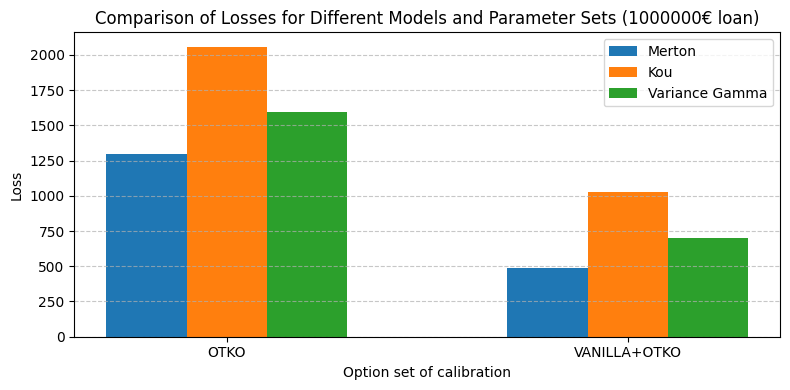

In [201]:
# Extract data for plotting
model_names = ['Merton', 'Kou', 'Variance Gamma']
avg_loss_merton = [avg_loss_merton1, avg_loss_merton2]
avg_loss_kou = [avg_loss_kou1, avg_loss_kou2]
avg_loss_vg = [avg_loss_vg1, avg_loss_vg2]

print(avg_loss_merton, avg_loss_kou, avg_loss_vg)
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8,4))

bar_width = 0.2
index = np.arange(len(options))

# Plot the first group of columns
plt.bar(index - bar_width, avg_loss_merton, bar_width, label='Merton')
plt.bar(index, avg_loss_kou, bar_width, label='Kou')
plt.bar(index + bar_width, avg_loss_vg, bar_width, label='Variance Gamma')

# Add labels, legends, etc.
plt.xlabel('Option set of calibration')
plt.ylabel('Loss')
plt.title(f'Comparison of Losses for Different Models and Parameter Sets ({loan}€ loan)')
plt.xticks(index, options)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.style.use('bmh')

# Show the plot or save it to a file
plt.tight_layout()
plt.show()


### 2. Evaluation of outcomes

#### 2.1 Evaluation of the loss distributions 

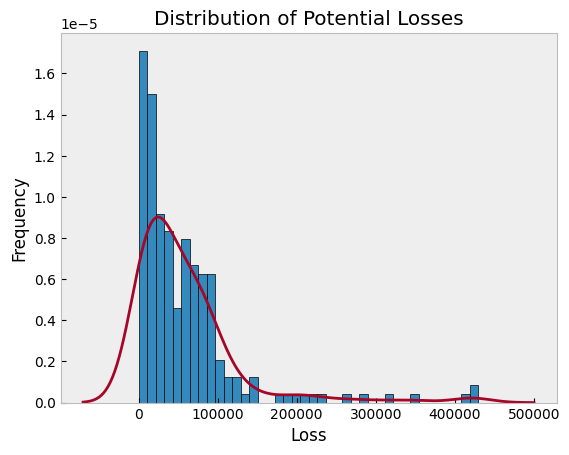

In [202]:
mask = (loss_merton1 != 0)
positive_loss_merton1 = loss_merton1[mask]
 
# Assuming you have a list of potential losses called 'potential_losses'
plt.hist(positive_loss_merton1, density=True, bins=40, edgecolor='black')
sns.kdeplot(positive_loss_merton1, fill=False)
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Potential Losses')
plt.grid(); plt.show()


#### 2.2 Evaluation of the profit&loss distribution

##### Merton Jump Diffusion

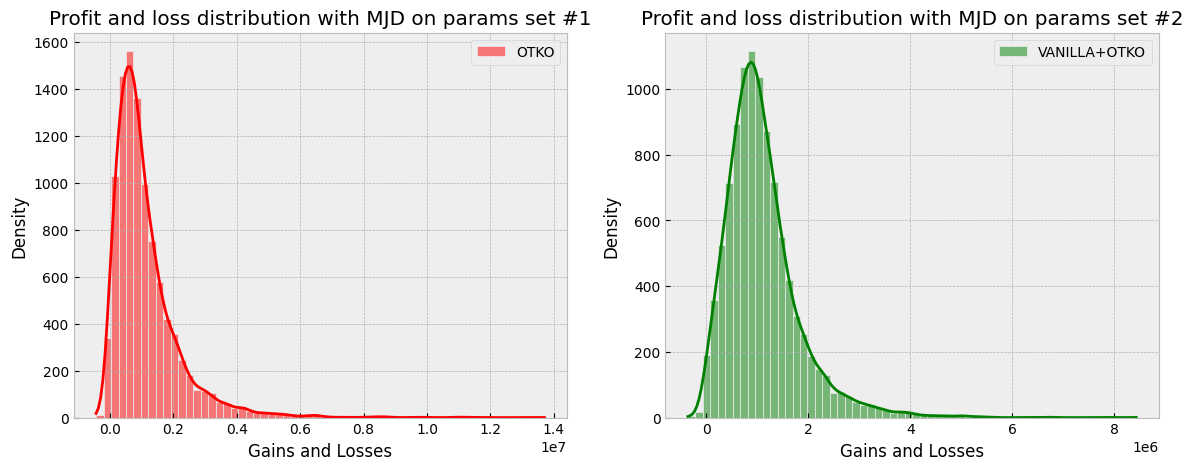

In [203]:
fig2_2, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

colors = ['red', 'green']

for i in range(2):
    dist_ = f'gain_loss_merton{i+1}'
    dist = locals()[dist_]
    sns.histplot(dist, ax=ax[i], bins=60, kde=True, color= colors[i], label=options[i])
    ax[i].set_xlabel('Gains and Losses')
    ax[i].set_ylabel('Density')
    ax[i].set_title(f'Profit and loss distribution with MJD on params set #{i+1}')
    ax[i].grid(True); ax[i].legend()
plt.show()

In [204]:
vaR_merton = np.zeros(len(options))
confidence_level = 0.99
print(f'{confidence_level * 100}% Value-at-Risk for Merton model: \n')
for i in range(len(options)): 
    dist_ = f'gain_loss_merton{i+1}'
    dist = locals()[dist_]
    vaR_merton[i] = np.percentile(dist, 100 * (1 - confidence_level))
    print(f'> PARAMS SET #{i+1} [{options[i]}]: {vaR_merton[i]}')

99.0% Value-at-Risk for Merton model: 

> PARAMS SET #1 [OTKO]: -44311.33596104095
> PARAMS SET #2 [VANILLA+OTKO]: 6421.856294879782


##### Kou Jump Diffusion

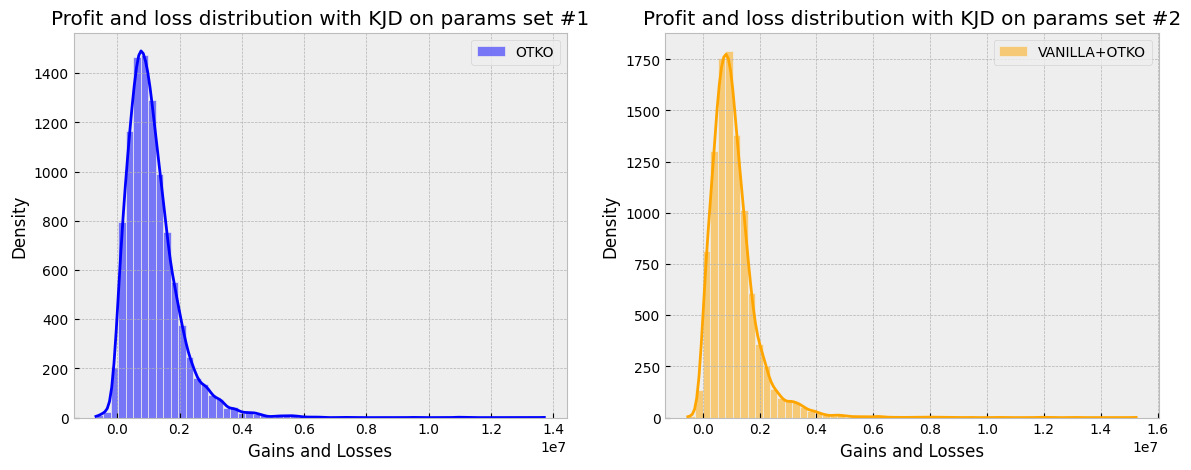

In [205]:
fig2_3, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

colors = ['blue','orange']

for i in range(2):
    dist_ = f'gain_loss_kou{i+1}'
    dist = locals()[dist_]
    sns.histplot(dist, ax=ax[i], bins=60, kde=True, color= colors[i], label=options[i])
    ax[i].set_xlabel('Gains and Losses')
    ax[i].set_ylabel('Density')
    ax[i].set_title(f'Profit and loss distribution with KJD on params set #{i+1}')
    ax[i].grid(True); ax[i].legend()
plt.show()

In [206]:
vaR_kou = np.zeros(len(options))
confidence_level = 0.99
print(f'{confidence_level * 100}% Value-at-Risk for Kou model: \n')
for i in range(len(options)): 
    dist_ = f'gain_loss_kou{i+1}'
    dist = locals()[dist_]
    vaR_kou[i] = np.percentile(dist, 100 * (1 - confidence_level))
    print(f'> PARAMS SET #{i+1} [{options[i]}]: {vaR_kou[i]}')

99.0% Value-at-Risk for Kou model: 

> PARAMS SET #1 [OTKO]: -46697.58124974684
> PARAMS SET #2 [VANILLA+OTKO]: -20161.95699791493


##### Variance Gamma model

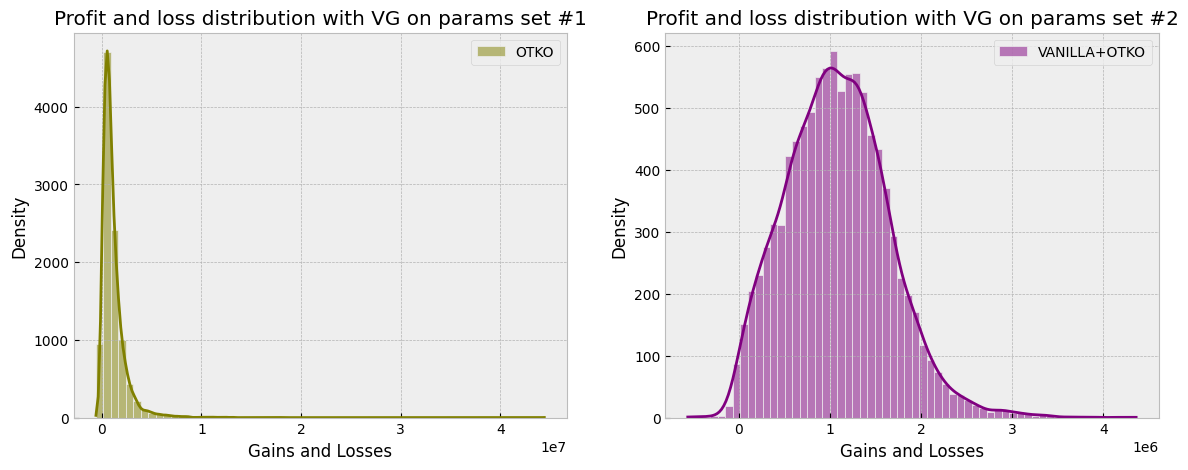

In [207]:
fig2_4, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

colors = ['olive', 'purple']

for i in range(2):
    dist_ = f'gain_loss_vg{i+1}'
    dist = locals()[dist_]
    sns.histplot(dist, ax=ax[i], bins=60, kde=True, color= colors[i], label=options[i])
    ax[i].set_xlabel('Gains and Losses')
    ax[i].set_ylabel('Density')
    ax[i].set_title(f'Profit and loss distribution with VG on params set #{i+1}')
    ax[i].grid(True); ax[i].legend()
plt.show()

In [208]:
vaR_vg = np.zeros(len(options))
confidence_level = 0.99
print(f'{confidence_level * 100}% Value-at-Risk for Varinace Gamma model: \n')
for i in range(len(options)): 
    dist_ = f'gain_loss_vg{i+1}'
    dist = locals()[dist_]
    vaR_vg[i] = np.percentile(dist, 100 * (1 - confidence_level))
    print(f'> PARAMS SET #{i+1} [{options[i]}]: {vaR_vg[i]}')

99.0% Value-at-Risk for Varinace Gamma model: 

> PARAMS SET #1 [OTKO]: -59749.00806993926
> PARAMS SET #2 [VANILLA+OTKO]: 7713.84281784819


In [116]:
# gain_loss_array_merton = [gain_loss_merton1, gain_loss_merton2, gain_loss_merton3]
# gain_loss_array_kou = [gain_loss_kou1, gain_loss_kou2, gain_loss_kou3]
# gain_loss_array_vg = [gain_loss_vg1, gain_loss_vg2, gain_loss_vg3]

# # Create a figure and axis
# fig, ax = plt.subplots(figsize=(10, 6))
# 
# # Create grouped boxplots for each model
# box_width = 0.2
# index = np.arange(3)
# 
# # Adjust positions for boxplots
# positions_merton = index - box_width
# positions_kou = index
# positions_vg = index + box_width
# 
# # Create the boxplots for each model and set
# boxprops = dict(linewidth=1.5, color='darkblue')
# medianprops = dict(linestyle='-', linewidth=1.5, color='black')
# 
# # Use patch_artist=True to enable setting the facecolor
# bplot1 = ax.boxplot(loss_array_merton, positions=positions_merton, widths=box_width, patch_artist=True, boxprops=boxprops, medianprops=medianprops, labels=options, showfliers=False)
# bplot2 = ax.boxplot(loss_array_kou, positions=positions_kou, widths=box_width, patch_artist=True, boxprops=boxprops, medianprops=medianprops, showfliers=False)
# bplot3 = ax.boxplot(loss_array_vg, positions=positions_vg, widths=box_width, patch_artist=True, boxprops=boxprops, medianprops=medianprops, showfliers=False)
# 
# # Customize the box colors
# colors = ['lightblue', 'lightgreen', 'lightcoral']
# for box in [bplot1, bplot2, bplot3]:
#     for patch, color in zip(box['boxes'], colors):
#         patch.set_facecolor(color)
# 
# # Add labels, legends, etc.
# plt.xlabel('Parameter Sets')
# plt.ylabel('Loss')
# plt.title(f'Comparison of Loss Distributions for Different Parameter Sets. ({loan}€ loan)')
# plt.xticks(index, ['Merton', 'Kou', 'VG'])
# plt.legend(options)
# plt.grid(True)
# # 
# # Show the plot or save it to a file
# plt.tight_layout()
# plt.show()


NameError: name 'gain_loss_merton3' is not defined